<a href="https://colab.research.google.com/github/MohonaMohsin/Bird-CNN-Image-Classifier/blob/main/Bird_CNN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Path to Bird dataset folder
DATA_DIR = '/content/drive/MyDrive/Bird Species Dataset'
print("✅ Dataset path:", DATA_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset path: /content/drive/MyDrive/Bird Species Dataset


In [ ]:
# Check classes
classes = os.listdir(DATA_DIR)
print("Bird Species Classes:", classes)

Bird Species Classes: ['EMPEROR PENGUIN', 'FLAMINGO', 'CARMINE BEE-EATER', 'DOWNY WOODPECKER', 'BARN OWL', 'AMERICAN GOLDFINCH']


#  Data Validation & Preview

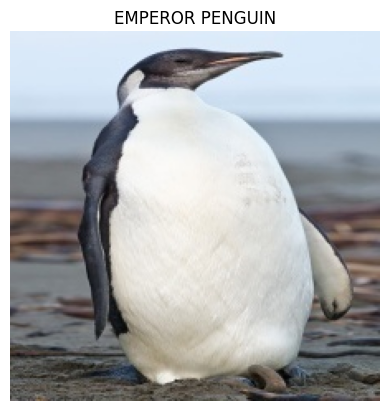

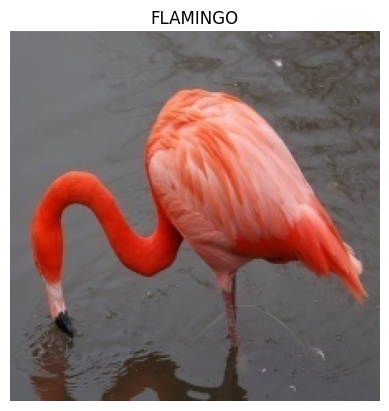

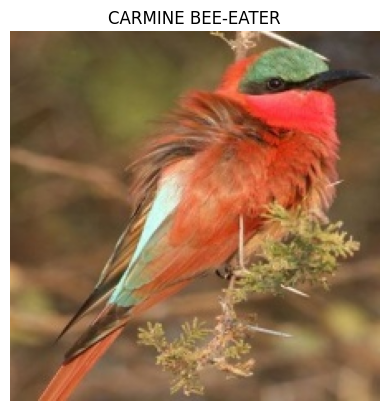

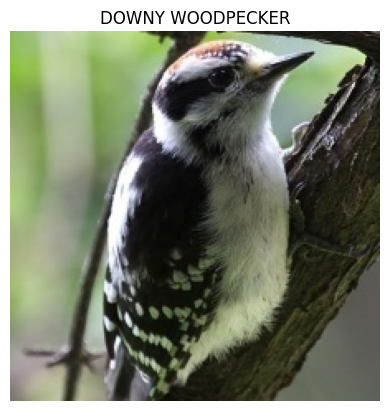

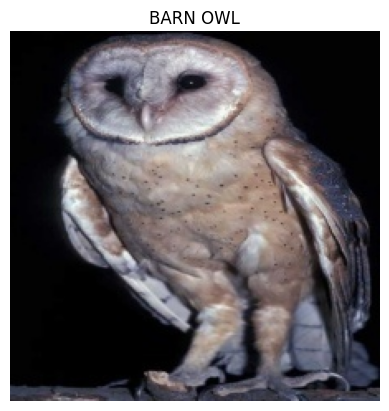

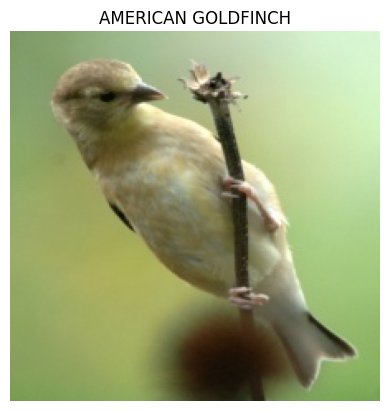

In [ ]:
import imghdr
import cv2
import matplotlib.pyplot as plt

# Allowed image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Remove incompatible images
for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)
        try:
            tip = imghdr.what(img_path)
            if tip not in image_exts:
                os.remove(img_path)
                print(f" Removed incompatible image: {img_path}")
        except Exception as e:
            os.remove(img_path)
            print(f" Removed problematic image: {img_path}, Error: {e}")

# Preview one image from each class
for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    sample_img = os.listdir(cls_path)[0]
    img = cv2.imread(os.path.join(cls_path, sample_img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
    plt.show()


#Load Data

In [ ]:
import tensorflow as tf

# Load images directly from Drive
dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int'  # multi-class integer labels
)

Found 811 files belonging to 6 classes.


In [ ]:
# Normalize
dataset = dataset.map(lambda x, y: (x/255, y))

Split into train/val/test

In [ ]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size) + 1
test_size = int(0.1 * dataset_size) + 1

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size).take(test_size)

print(f"✅ Dataset split: Train={train_size}, Val={val_size}, Test={test_size}")

✅ Dataset split: Train=18, Val=6, Test=3


#Model Development

In [ ]:
from tensorflow.keras import layers, models

def make_model_multi(input_shape=IMG_SIZE+(3,), num_classes=6): # Changed num_classes to 6
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16,(3,3),activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(32,(3,3),activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(64,(3,3),activation='relu'), layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')  # multi-class
    ])
    return model

model = make_model_multi(num_classes=len(classes)) # Pass the actual number of classes
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,770,982 (56.35 MB)

 Trainable params: 14,770,982 (56.35 MB)

 Non-trainable params: 0 (0.00 B)

#Train the model

In [ ]:
# Train
logdir = '/content/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tensorboard_callback]
)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2109 - loss: 2.8748 - val_accuracy: 0.4427 - val_loss: 1.3953
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5942 - loss: 1.1490 - val_accuracy: 0.7344 - val_loss: 0.7549
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8050 - loss: 0.5706 - val_accuracy: 0.8958 - val_loss: 0.3276
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.8937 - loss: 0.3142 - val_accuracy: 0.9479 - val_loss: 0.1622
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9429 - loss: 0.1900 - val_accuracy: 0.9479 - val_loss: 0.1407
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.9771 - loss: 0.0983 - val_accuracy: 0.9531 - val_loss: 0.1459
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9393 - loss: 0.1452 - val_accuracy: 0.9844 - val_loss: 0.0962
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9770 - loss: 0.0736 - val_accuracy: 0.9896 - val_loss:

#Evaluate

In [ ]:
import numpy as np
from tensorflow.keras.metrics import Precision, Recall, Accuracy

precision = Precision()
recall = Recall()
accuracy = Accuracy()

for batch in test_ds:
    X, y = batch
    yhat = model.predict(X)
    yhat_labels = np.argmax(yhat, axis=1)
    precision.update_state(y, yhat_labels)
    recall.update_state(y, yhat_labels)
    accuracy.update_state(y, yhat_labels)

print("Precision:", precision.result().numpy())
print("Recall:", recall.result().numpy())
print("Accuracy:", accuracy.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


# Test

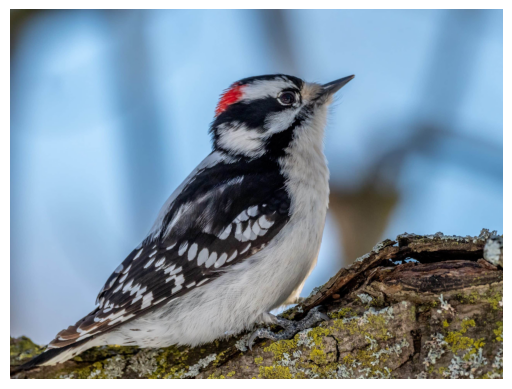

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Bird Species: DOWNY WOODPECKER


In [ ]:
# Test
img_path = '/content/drive/MyDrive/bird_test/DOWNY WOODPECKER_image.jpg'
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

img_resized = tf.image.resize(img_rgb, (256,256))
img_scaled = np.expand_dims(img_resized/255, axis=0)

yhat = model.predict(img_scaled)
pred_class = classes[np.argmax(yhat)]
print("Predicted Bird Species:", pred_class)

#Save Model


In [17]:
import os
os.makedirs('/content/models', exist_ok=True)
model.save('/content/models/bird_classifier.keras')
print("Saved model at /content/models/bird_classifier.keras")

Saved model at /content/models/bird_classifier.keras
